In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#!unzip gdrive/MyDrive/dataset.zip

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'glasses_noGlasses'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

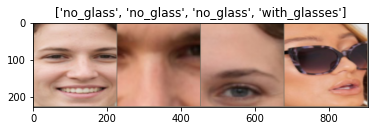

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def get_trained_model(model_conv):
  for param in model_conv.parameters():
      param.requires_grad = False

  # Parameters of newly constructed modules have requires_grad=True by default
  num_ftrs = model_conv.fc.in_features
  model_conv.fc = nn.Linear(num_ftrs, 2)

  model_conv = model_conv.to(device)

  criterion = nn.CrossEntropyLoss()

  # Observe that only parameters of final layer are being optimized as
  # opposed to before.
  optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
  return train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                     num_epochs=25)

In [ ]:
model_1 = models.resnet18(pretrained=True)
model_1 = get_trained_model(model_1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3389 Acc: 0.8613
valid Loss: 0.0196 Acc: 0.9967

Epoch 1/24
----------
train Loss: 0.3349 Acc: 0.8742
valid Loss: 0.0156 Acc: 0.9950

Epoch 2/24
----------
train Loss: 0.3850 Acc: 0.8631
valid Loss: 0.0218 Acc: 0.9934

Epoch 3/24
----------
train Loss: 0.3721 Acc: 0.8696
valid Loss: 0.0118 Acc: 0.9967

Epoch 4/24
----------
train Loss: 0.3096 Acc: 0.8880
valid Loss: 0.0300 Acc: 0.9851

Epoch 5/24
----------
train Loss: 0.3157 Acc: 0.8868
valid Loss: 0.1295 Acc: 0.9586

Epoch 6/24
----------
train Loss: 0.3045 Acc: 0.8970
valid Loss: 0.0431 Acc: 0.9851

Epoch 7/24
----------
train Loss: 0.2648 Acc: 0.9000
valid Loss: 0.0143 Acc: 0.9967

Epoch 8/24
----------
train Loss: 0.2114 Acc: 0.9154
valid Loss: 0.0127 Acc: 0.9983

Epoch 9/24
----------
train Loss: 0.2345 Acc: 0.8994
valid Loss: 0.0270 Acc: 0.9901

Epoch 10/24
----------
train Loss: 0.2371 Acc: 0.9031
valid Loss: 0.0155 Acc: 0.9950

Epoch 11/24
----------
train Loss: 0.2463 Acc: 0.9031
valid Loss: 0.0143 Acc: 0.9967



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


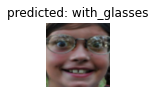

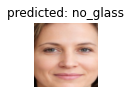

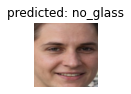

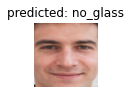

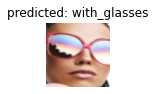

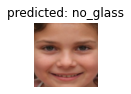

In [ ]:
visualize_model(model_1)

In [ ]:
for root, _, files in os.walk('glasses_noGlasses'):
  for file in files:
    if ',' in file:
      new_name = file.replace(',', '_')
      os.rename(os.path.join(root, file), os.path.join(root, new_name))
      print(f'Renamed {file} to {new_name}')

Renamed 23.e25609ab-abd8-45c6-af5c-977088ab3ed4._CR0,0,970,600_PT0_SX970__.jpg to 23.e25609ab-abd8-45c6-af5c-977088ab3ed4._CR0_0_970_600_PT0_SX970__.jpg
Renamed 232.e25609ab-abd8-45c6-af5c-977088ab3ed4._CR0,0,970,600_PT0_SX970__.jpg to 232.e25609ab-abd8-45c6-af5c-977088ab3ed4._CR0_0_970_600_PT0_SX970__.jpg
Renamed 257.e25609ab-abd8-45c6-af5c-977088ab3ed4._CR0,0,970,600_PT0_SX970__.jpg to 257.e25609ab-abd8-45c6-af5c-977088ab3ed4._CR0_0_970_600_PT0_SX970__.jpg
Renamed 49.e25609ab-abd8-45c6-af5c-977088ab3ed4._CR0,0,970,600_PT0_SX970__.jpg to 49.e25609ab-abd8-45c6-af5c-977088ab3ed4._CR0_0_970_600_PT0_SX970__.jpg
Renamed 206.e25609ab-abd8-45c6-af5c-977088ab3ed4._CR0,0,970,600_PT0_SX970__.jpg to 206.e25609ab-abd8-45c6-af5c-977088ab3ed4._CR0_0_970_600_PT0_SX970__.jpg


In [ ]:
labels = []
def create_csv(name):
  with open(f'{name}.csv', 'w') as f:
    for root, _, files in os.walk(os.path.join('glasses_noGlasses', name)):
      for file in files:
        label = os.path.basename(root)
        path = os.path.join(label, file)
        if os.path.splitext(file)[1] == '.jpg':
          if label not in labels:
            labels.append(label)
          f.write(f'{path}, {labels.index(label)}\n')

In [ ]:
for x in ['train', 'valid']:
  create_csv(x)

In [ ]:
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd

In [ ]:
def pil_loader(path):
  with open(path, "rb") as f:
      img = Image.open(f)
      return img.convert("RGB")

class MyDataset(Dataset):
  def __init__(self, root, csv_file, transform):
    self.dataset_descr = pd.read_csv(csv_file)
    self.root = root
    self.transform = transform
  
  def __len__(self):
    return len(self.dataset_descr)

  def __getitem__(self, idx):
    info = self.dataset_descr.iloc[idx]

    img_name = os.path.join(self.root, info[0])
    image = pil_loader(img_name)
    label = torch.tensor(int(info[1]))
    image = self.transform(image)

    return image, label

In [ ]:
data_dir = 'glasses_noGlasses'
image_datasets = {x: MyDataset(os.path.join(data_dir, x), f'{x}.csv',
                               data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
              for x in ['train', 'valid']}
class_names = labels

In [ ]:
model_2 = models.resnet18(pretrained=True)
model_2 = get_trained_model(model_2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/24
----------
train Loss: 0.3074 Acc: 0.8096
valid Loss: 0.0961 Acc: 0.9238

Epoch 1/24
----------
train Loss: 0.3019 Acc: 0.8317
valid Loss: 0.0141 Acc: 0.9503

Epoch 2/24
----------
train Loss: 0.2471 Acc: 0.8434
valid Loss: 0.0263 Acc: 0.9437

Epoch 3/24
----------
train Loss: 0.3252 Acc: 0.8197
valid Loss: 0.0185 Acc: 0.9487

Epoch 4/24
----------
train Loss: 0.2870 Acc: 0.8345
valid Loss: 0.0229 Acc: 0.9437

Epoch 5/24
----------
train Loss: 0.2428 Acc: 0.8444
valid Loss: 0.0165 Acc: 0.9454

Epoch 6/24
----------
train Loss: 0.2512 Acc: 0.8425
valid Loss: 0.0601 Acc: 0.9387

Epoch 7/24
----------
train Loss: 0.2190 Acc: 0.8570
valid Loss: 0.0286 Acc: 0.9421

Epoch 8/24
----------
train Loss: 0.1993 Acc: 0.8557
valid Loss: 0.0132 Acc: 0.9503

Epoch 9/24
----------
train Loss: 0.2113 Acc: 0.8557
valid Loss: 0.0170 Acc: 0.9454

Epoch 10/24
----------
train Loss: 0.2238 Acc: 0.8508
valid Loss: 0.0214 Acc: 0.9421

Epoch 11/24
----------
train Loss: 0.1877 Acc: 0.8616
valid Loss

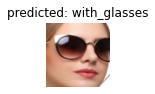

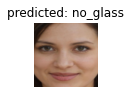

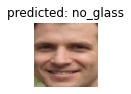

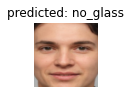

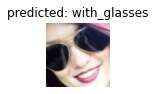

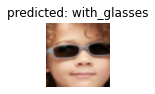

In [ ]:
visualize_model(model_2)

In [ ]:
print(image_datasets['train'][0][0].size())

torch.Size([3, 224, 224])


In [ ]:
import torch.nn as nn
from torch.nn.functional import relu


class MyConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5) # 220x220
    self.pool = nn.MaxPool2d(2, 2) # 110x110
    self.conv2 = nn.Conv2d(6, 16, 5) # 106x106 -> pool -> 53x53
    self.fc1 = nn.Linear(16 * 53 * 53, 120) 
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 3)

  def forward(self, x):
    x = self.pool(relu(self.conv1(x)))
    x = self.pool(relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = relu(self.fc1(x))
    x = relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model_3 = MyConvNet()
model_3 = model_3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
train_model(model_3, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3971 Acc: 0.7795
valid Loss: 0.3333 Acc: 0.8411

Epoch 1/24
----------
train Loss: 0.2298 Acc: 0.8514
valid Loss: 0.1524 Acc: 0.8874

Epoch 2/24
----------
train Loss: 0.1874 Acc: 0.8674
valid Loss: 0.1177 Acc: 0.9172

Epoch 3/24
----------
train Loss: 0.1798 Acc: 0.8733
valid Loss: 0.1876 Acc: 0.8907

Epoch 4/24
----------
train Loss: 0.1750 Acc: 0.8745
valid Loss: 0.0742 Acc: 0.9321

Epoch 5/24
----------
train Loss: 0.1505 Acc: 0.8813
valid Loss: 0.1689 Acc: 0.8990

Epoch 6/24
----------
train Loss: 0.1395 Acc: 0.8883
valid Loss: 0.0780 Acc: 0.9205

Epoch 7/24
----------
train Loss: 0.1060 Acc: 0.9034
valid Loss: 0.0610 Acc: 0.9354

Epoch 8/24
----------
train Loss: 0.0922 Acc: 0.9043
valid Loss: 0.0683 Acc: 0.9338

Epoch 9/24
----------
train Loss: 0.0924 Acc: 0.9022
valid Loss: 0.0531 Acc: 0.9371

Epoch 10/24
----------
train Loss: 0.0923 Acc: 0.9071
valid Loss: 0.0626 Acc: 0.9338

Epoch 11/24
----------
train Loss: 0.0850 Acc: 0.9071
valid Loss

MyConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

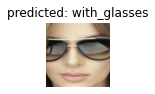

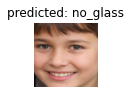

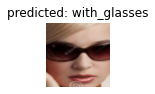

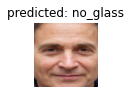

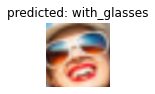

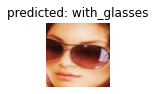

In [ ]:
visualize_model(model_3)